In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import os
import warnings
import torch
import pandas as pd
import numpy as np
import torch.nn.functional as F
from tqdm.auto import tqdm
from pathlib import Path
import datamol as dm
from rdkit.Chem import SaltRemover
from sklearn.model_selection import GroupShuffleSplit

In [18]:
warnings.simplefilter("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
dm.disable_rdkit_log()

In [3]:
from molfeat.trans.graph.adj import PYGGraphTransformer
from molfeat.calc.atom import AtomCalculator
from molfeat.calc.bond import EdgeMatCalculator

In [4]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.utils import degree

In [5]:
featurizer = PYGGraphTransformer(
    atom_featurizer=AtomCalculator(), 
    bond_featurizer=EdgeMatCalculator()
)

In [6]:
class DTset(Dataset):
    def __init__(self, smiles, y, featurizer):
        super().__init__()
        self.smiles = smiles
        self.featurizer = featurizer
        self.featurizer.auto_self_loop()
        self.y = torch.tensor(y).unsqueeze(-1).float()
        self.transformed_mols = self.featurizer(smiles)
        self._degrees = None

    @property
    def num_atom_features(self):
        return self.featurizer.atom_dim

    @property
    def num_output(self):
        return self.y.shape[-1]
    
    def __len__(self):
        return len(self.transformed_mols)
    
    @property
    def num_bond_features(self):
        return self.featurizer.bond_dim
    

    @property
    def degree(self):
        if self._degrees is  None:
            max_degree = -1
            for data in self.transformed_mols:
                d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
                max_degree = max(max_degree, int(d.max()))
            # Compute the in-degree histogram tensor
            deg = torch.zeros(max_degree + 1, dtype=torch.long)
            for data in self.transformed_mols:
                d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
                deg += torch.bincount(d, minlength=deg.numel())
            self._degrees = deg
        return self._degrees

    def collate_fn(self, **kwargs):
        # luckily the molfeat featurizer provides a collate functoin for PyG
        return self.featurizer.get_collate_fn(**kwargs)
    
    def __getitem__(self, index):
        return self.transformed_mols[index], self.y[index]

In [8]:
def load_dataset(uri: str, readout_col: str):
    """ Loads the MoleculeNet dataset """
    df = pd.read_csv(uri)
    smiles = df["smiles"].values
    y = df[readout_col].values
    return smiles, y


def preprocess_smiles(smi: str) -> str:
    """ Preprocesses the SMILES string """
    mol = dm.to_mol(smi, ordered=True, sanitize=False)    
    try: 
        mol = dm.sanitize_mol(mol)
    except:
        mol = None
            
    if mol is None: 
        return
        
    mol = dm.standardize_mol(mol, disconnect_metals=True)
    remover = SaltRemover.SaltRemover()
    mol = remover.StripMol(mol, dontRemoveEverything=True)

    return dm.to_smiles(mol)


def scaffold_split(smiles):
    """In line with common practice, we will use the scaffold split to evaluate our models"""
    scaffolds = [dm.to_smiles(dm.to_scaffold_murcko(dm.to_mol(smi))) for smi in smiles]
    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    return next(splitter.split(smiles, groups=scaffolds))

In [19]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

smiles, y = load_dataset(DATA / "EGFR_compounds_lipinski.csv", "pIC50")
smiles = np.array([preprocess_smiles(smi) for smi in smiles])
smiles = np.array([smi for smi in smiles if dm.to_mol(smi) is not None])

In [22]:
train_ind, test_ind = scaffold_split(smiles)

In [25]:
train_smiles = smiles[train_ind]
train_y = y[train_ind]
test_smiles = smiles[test_ind]
test_y = y[test_ind]

In [26]:
train_dt = DTset(train_smiles, train_y, featurizer)
test_dt = DTset(test_smiles, test_y, featurizer)
generator = torch.Generator().manual_seed(42)

In [28]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dt, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dt.collate_fn(return_pair=False))
test_loader = DataLoader(test_dt, batch_size=BATCH_SIZE, shuffle=False, collate_fn=test_dt.collate_fn(return_pair=False))

In [40]:
from torch_geometric.nn.models import PNA
from torch_geometric.nn import global_add_pool

DEVICE = "cpu"
NUM_EPOCHS = 20
LEARNING_RATE = 5e-4
PNA_AGGREGATORS = ['mean', 'min', 'max', 'std']
PNA_SCALERS = ['identity', 'amplification', 'attenuation']

In [41]:
model = PNA(in_channels=train_dt.num_atom_features, 
            hidden_channels=128, 
            num_layers=3,
            out_channels=train_dt.num_output, 
            dropout=0.1, 
            act="relu",
            edge_dim=train_dt.num_bond_features,
            aggregators=PNA_AGGREGATORS,
            scalers=PNA_SCALERS,
            deg=train_dt.degree)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [43]:
# Train
model = model.to(DEVICE).float()

maes = []
with tqdm(range(NUM_EPOCHS)) as pbar:
    for epoch in pbar:
        losses = []
        model.train()
        for data in train_loader:
            data = data.to(DEVICE)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, edge_attr=data.edge_attr)
            out = global_add_pool(out, data.batch)
            loss = F.mse_loss(out.squeeze(), data.y)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        model.eval()
        test_y_hat = []
        test_y_true = []
        with torch.no_grad():
            for data in test_loader:
                data = data.to(DEVICE)
                out = model(data.x, data.edge_index, edge_attr=data.edge_attr)
                out = global_add_pool(out, data.batch)
                test_y_hat.append(out.detach().cpu().squeeze())
                test_y_true.append(data.y)
                
        test_y_hat = torch.cat(test_y_hat).numpy()
        test_y_true = torch.cat(test_y_true).numpy()
        mae = mean_absolute_error(test_y_true, test_y_hat)
        maes.append(mae)

        pbar.set_description(f"Epoch {epoch} - Loss {np.mean(losses):.3f} - MAE Test {mae:.3f} ")

  0%|          | 0/20 [00:00<?, ?it/s]

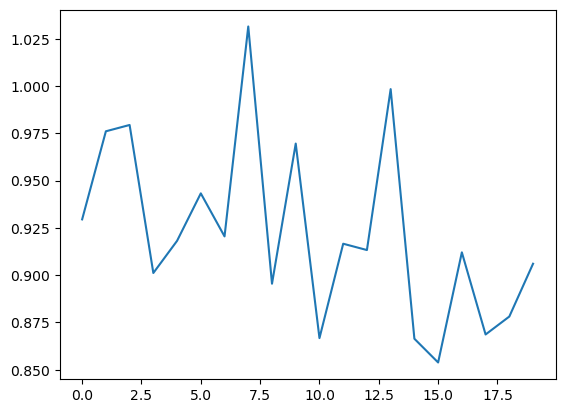

In [44]:
plt.plot(maes)

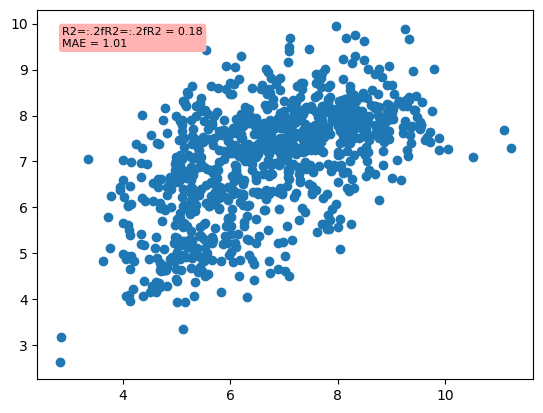

In [39]:
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import pyplot as plt


plt.scatter(test_y_true, test_y_hat)
_ =plt.gca().annotate(
    "R2 = {:.2f}\nMAE = {:.2f}".format(r2, mae), 
    xy=(0.05,0.9),  
    xycoords='axes fraction', 
    size=8,
    bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none")
)

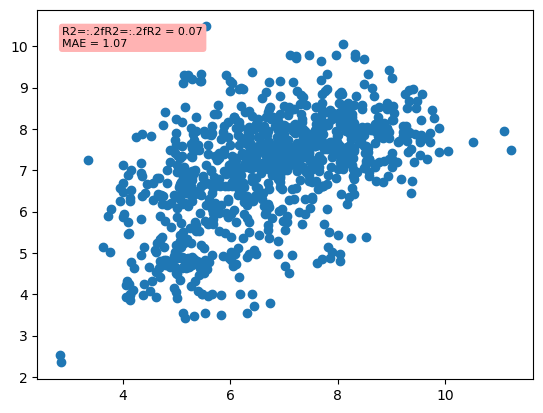

In [37]:
from sklearn.metrics import r2_score, mean_absolute_error
from matplotlib import pyplot as plt

model.eval()
test_y_hat = []
test_y_true = []
with torch.no_grad():
    for data in test_loader:
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index, edge_attr=data.edge_attr)
        out = global_add_pool(out, data.batch)
        test_y_hat.append(out.detach().cpu().squeeze())
        test_y_true.append(data.y)

test_y_hat = torch.cat(test_y_hat).numpy()
test_y_true = torch.cat(test_y_true).numpy()

r2 = r2_score(test_y_true, test_y_hat)
mae = mean_absolute_error(test_y_true, test_y_hat)

plt.scatter(test_y_true, test_y_hat)
_ =plt.gca().annotate(
    "R2=:.2fR2=:.2fR2 = {:.2f}\nMAE = {:.2f}".format(r2, mae), 
    xy=(0.05,0.9),  
    xycoords='axes fraction', 
    size=8,
    bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none")
)